# Setting up notebook for modelling

In [1]:
!rm -r ../root/.kaggle
!mkdir ../root/.kaggle
!cp kaggle.json ../root/.kaggle
!chmod 600 ../root/.kaggle/kaggle.json
!rm -r sample_data
!pip install efficientnet-pytorch

rm: cannot remove '../root/.kaggle': No such file or directory
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=9003408bbb509f71e6627632b0392ae0fda42b42a374e0c686c650687917b976
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [2]:
!kaggle datasets download umangjpatel/pap-smear-datasets --unzip
!rm -r herlev_pap_smear
!rm -r sipakmed_fci_pap_smear

100% 6.44G/6.44G [02:23<00:00, 46.5MB/s]
100% 6.44G/6.44G [02:23<00:00, 48.3MB/s]


In [0]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import efficientnet
from fastai.utils.ipython import *
from fastai.callbacks.tracker import SaveModelCallback
from sklearn.model_selection import StratifiedKFold

In [4]:
path = Path(".")
path.ls()

[PosixPath('.config'),
 PosixPath('kaggle.json'),
 PosixPath('sipakmed_wsi_pap_smear')]

In [5]:
data_init = (ImageList.from_folder(path/"sipakmed_wsi_pap_smear")
            .split_none()
            .label_from_folder())
data_init

LabelLists;

Train: LabelList (966 items)
x: ImageList
Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048)
y: CategoryList
abnormal_Dyskeratotic,abnormal_Dyskeratotic,abnormal_Dyskeratotic,abnormal_Dyskeratotic,abnormal_Dyskeratotic
Path: sipakmed_wsi_pap_smear;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: sipakmed_wsi_pap_smear;

Test: None

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
skf

StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

In [0]:
!mkdir sipakmed_wsi_pap_smear/models

In [0]:
def model_callback(model, model_name):
  return [SaveModelCallback(model, every="improvement", monitor="accuracy", name=model_name)]

In [0]:
tfms = get_transforms(flip_vert=True, max_warp=0.0, max_rotate=60.0, max_zoom=1.0)

In [10]:
our_metrics = [accuracy, Precision(average="macro"), Recall(average="macro"), FBeta(average="macro"), KappaScore(weights="quadratic")]
our_metrics

[<function fastai.metrics.accuracy>,
 Precision(average='macro', pos_label=1, eps=1e-09),
 Recall(average='macro', pos_label=1, eps=1e-09),
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=2),
 KappaScore(weights='quadratic')]

# K-Fold Training Process
* Loop through fold indices
* Load the fold data
* Initialize the learner with the fold data (with freezing)
* Train the learner
* Fine-tune the learner
* Repeat for different folds

In [0]:
idxs = [[train_idx, val_idx] for train_idx, val_idx in skf.split(data_init.x.items, data_init.y.items)]

In [0]:
fold1_idxs = idxs[0]
fold_data = (ImageList.from_folder(path/"sipakmed_wsi_pap_smear")
            .split_by_idxs(fold1_idxs[0], fold1_idxs[1])
            .label_from_folder()
            .transform(tfms, size=224)
            .databunch(bs=16)
            .normalize(imagenet_stats))

In [13]:
learner = Learner(fold_data, efficientnet.EfficientNetB3(fold_data), metrics=our_metrics).to_fp16()
learner = learner.split([learner.model._conv_stem, learner.model._blocks, learner.model._conv_head])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


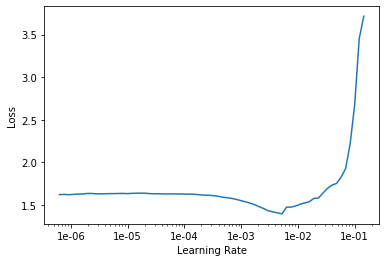

In [14]:
learner.lr_find()
learner.recorder.plot()

In [15]:
learner.fit_one_cycle(30, max_lr=slice(2e-03), callbacks=model_callback(learner, "best-effb3-fold1-stage1"))

Better model found at epoch 0 with accuracy value: 0.3322981297969818.
Better model found at epoch 1 with accuracy value: 0.6055900454521179.
Better model found at epoch 2 with accuracy value: 0.7360248565673828.
Better model found at epoch 3 with accuracy value: 0.8416149020195007.
Better model found at epoch 4 with accuracy value: 0.8757764101028442.
Better model found at epoch 5 with accuracy value: 0.8819875717163086.
Better model found at epoch 6 with accuracy value: 0.8850931525230408.
Better model found at epoch 7 with accuracy value: 0.9161490797996521.
Better model found at epoch 9 with accuracy value: 0.9254658222198486.
Better model found at epoch 16 with accuracy value: 0.9316770434379578.
Better model found at epoch 18 with accuracy value: 0.9378882050514221.
Better model found at epoch 20 with accuracy value: 0.9409937858581543.
Better model found at epoch 21 with accuracy value: 0.9503105878829956.
Better model found at epoch 23 with accuracy value: 0.9534161686897278.
B

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


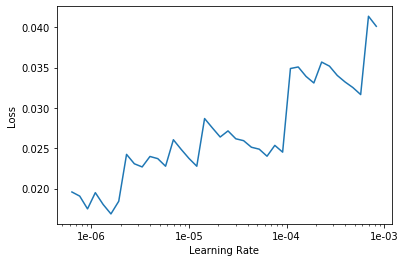

In [16]:
learner.load("best-effb3-fold1-stage1")
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [17]:
learner.fit_one_cycle(30, max_lr=slice(1.3e-06, 2e-04), callbacks=model_callback(learner, "best-effb3-fold1-stage2"))

Better model found at epoch 0 with accuracy value: 0.95652174949646.


In [0]:
fold2_idxs = idxs[1]
fold_data = (ImageList.from_folder(path/"sipakmed_wsi_pap_smear")
            .split_by_idxs(fold2_idxs[0], fold2_idxs[1])
            .label_from_folder()
            .transform(tfms, size=224)
            .databunch(bs=16)
            .normalize(imagenet_stats))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


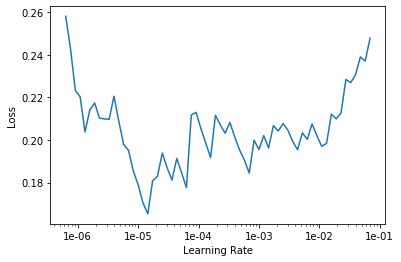

In [21]:
learner.load("best-effb3-fold1-stage2")
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [22]:
learner.fit_one_cycle(30, max_lr=slice(7e-06), callbacks=model_callback(learner, "best-effb3-fold2-stage1"))

Better model found at epoch 0 with accuracy value: 1.0.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


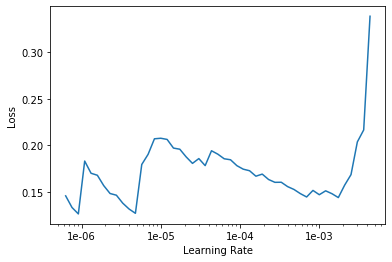

In [23]:
learner.load("best-effb3-fold2-stage1")
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [24]:
learner.fit_one_cycle(30, max_lr=slice(7e-07, 7e-07), callbacks=model_callback(learner, "best-effb3-fold2-stage2"))

Better model found at epoch 0 with accuracy value: 1.0.


In [0]:
fold3_idxs = idxs[2]
fold_data = (ImageList.from_folder(path/"sipakmed_wsi_pap_smear")
            .split_by_idxs(fold3_idxs[0], fold3_idxs[1])
            .label_from_folder()
            .transform(tfms, size=224)
            .databunch(bs=16)
            .normalize(imagenet_stats))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


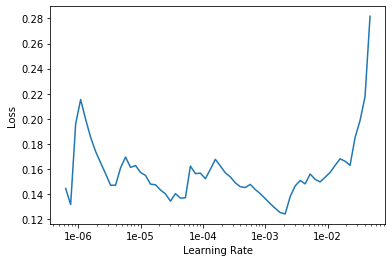

In [29]:
learner.purge()
learner.load("best-effb3-fold2-stage2")
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [30]:
learner.fit_one_cycle(30, max_lr=slice(1e-03), callbacks=model_callback(learner, "best-effb3-fold3-stage1"))

Better model found at epoch 0 with accuracy value: 1.0.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


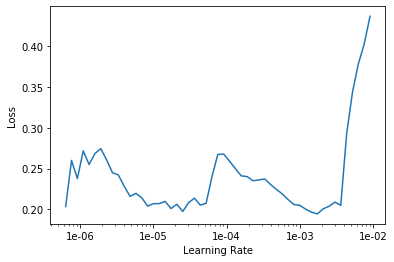

In [39]:
learner.load("best-effb3-fold3-stage1")
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [40]:
learner.fit_one_cycle(20, max_lr=slice(5e-04), callbacks=model_callback(learner, "best-effb3-fold3-stage2"))

Better model found at epoch 0 with accuracy value: 1.0.


In [0]:
all_data = (ImageList.from_folder(path/"sipakmed_wsi_pap_smear")
            .split_none()
            .label_from_folder()
            .transform(tfms, size=224)
            .databunch(bs=16)
            .normalize(imagenet_stats))

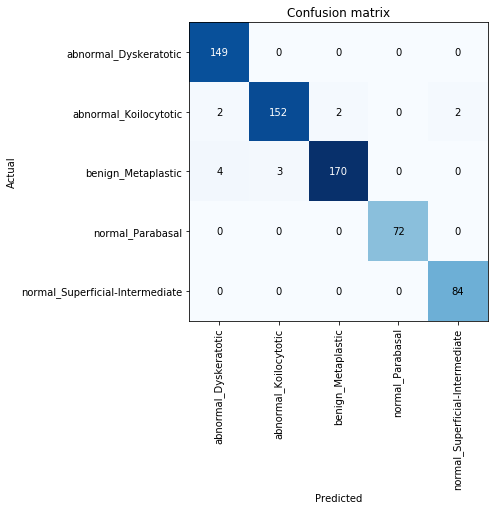

In [42]:
interp = ClassificationInterpretation.from_learner(learner, ds_type=DatasetType.Train)
interp.plot_confusion_matrix(figsize=(7, 7))

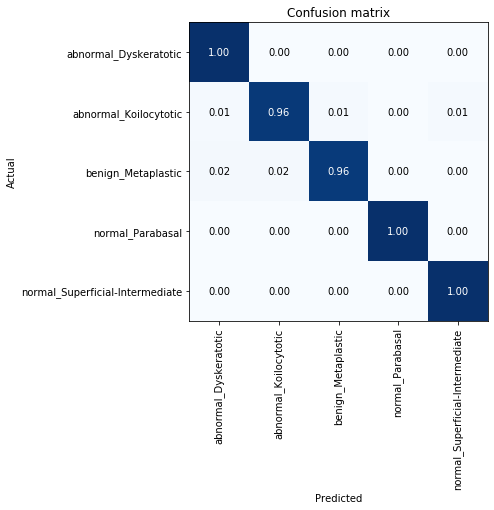

In [43]:
interp.plot_confusion_matrix(figsize=(7, 7), normalize=True)

In [49]:
val_learner = to_fp32(learner)
test_mets = [accuracy, Precision(average="macro"), Recall(average="macro"), FBeta(average="macro"), KappaScore(weights="quadratic")]
val_learner.validate(dl=all_data.train_dl, metrics=test_mets)

[0.09148381,
 tensor(0.9781),
 tensor(0.9809),
 tensor(0.9828),
 tensor(0.9824),
 tensor(0.9858)]

In [0]:
learner.export()